In [1]:
# if necessary, install NeuralGCM and dependencies
!python --version
!pip install -q -U neuralgcm dinosaur-dycore gcsfs
!pip install matplotlib

Python 3.12.2


# Forecasting quick start

This notebook uses ERA5 data and pretrained NeuralGCM model to make a weather forecast.

The forecast is made in 3 steps:
1. Slice of ERA5 data is regridded to model resolution
2. NeuralGCM model state is initialized and rolled out
3. Predictions and reference trajectory are combined for visualization

By default the notebook uses intermediate deterministic NeuralGCM 1.4° model. Other available checkpoints include deterministic 0.7°, 2.8° and stochastic 1.4° NeuralGCM variations.

```{tip}
You can run this notebook yourself in [Google Colab](https://colab.research.google.com/github/google-research/neuralgcm/blob/main/docs/inference_demo.ipynb). We recommend using a GPU or TPU runtime due to high memory and compute requirements.
```

<span style="color:green">NEW</span> Added import for image display, see at end of document \
<span style="color:green">New</span> You Need to install module cartopy

In [1]:
import gcsfs
import jax
import numpy as np
import pickle
import xarray

from dinosaur import horizontal_interpolation
from dinosaur import spherical_harmonic
from dinosaur import xarray_utils
import neuralgcm

import matplotlib.pyplot as plt
import cartopy

from PIL import Image
from IPython.display import display

gcs = gcsfs.GCSFileSystem(token='anon')

In [2]:
#! pip install xarray netCDF4 numpy

import xarray as xr

ersst_path = "./data/tos_Omon_GISS-E2-1-G_historical_r1i1p5f1_gn_200101-201412.nc"
ersst_data = xr.open_dataset(ersst_path)

Subset the data to be similar to NeuralGCM

## Load a pre-trained NeuralGCM model

```{caution}
Trained model weights are licensed for non-commercial use, under the Creative Commons [Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/) license (CC BY-NC-SA 4.0).
```

Pre-trained model checkpoints from the NeuralGCM paper are [available for download](https://console.cloud.google.com/storage/browser/gresearch/neuralgcm/04_30_2024) on Google Cloud Storage:

- Deterministic models:
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_0_7_deg.pkl`
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl`
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl`
- Stochastic models:
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_stochastic_1_4_deg.pkl`

## Need to train it on our own using the inputs from era5

In [3]:
drought_variables = [
    "precipitation",      # To track precipitation deficits
    "evaporation",        # Water loss through evaporation
    "soil_moisture",      # Soil water content for agricultural impacts
    "temperature",        # High temperatures linked to drought
    "specific_humidity",  # Tracks atmospheric moisture
    "surface_pressure",   # Indicator of regional pressure systems
    "sea_surface_temp",   # SST anomalies linked to teleconnections
]

In [4]:
model_name = 'neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl'  #@param ['neural_gcm_dynamic_forcing_deterministic_0_7_deg.pkl', 'neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl', 'neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl', 'neural_gcm_dynamic_forcing_stochastic_1_4_deg.pkl'] {type: "string"}

with gcs.open(f'gs://gresearch/neuralgcm/04_30_2024/{model_name}', 'rb') as f:
  ckpt = pickle.load(f)

model = neuralgcm.PressureLevelModel.from_checkpoint(ckpt)

/tmp/ipykernel_27885/1359244622.py:4: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  ckpt = pickle.load(f)


## Load ERA5 data from GCP/Zarr

See {doc}`datasets` for details. Leave this part


Select out a few days of data:

## Need to change start time and end time

Checklist: \
<span style="color:green">NEW</span> Different lon und lat bounds \
<span style="color:red">Decide on start and end time</span> \

In [15]:
#era5_path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
#full_era5 = xarray.open_zarr(gcs.get_mapper(era5_path), chunks=None)

#used for training as it is short, however empty amo_index and could be a longer range 
start_date = '2014-12-10'
end_date = '2014-12-20'

data_inner_steps = 24  # process every 24th hour

lat_bounds = [slice(34, 45), slice(34, 51)] 
lon_bounds = [slice(-24, 19), slice(-20, 10)]  

<span style="color:green"></span> Compute anomalies, trends, or indices such as the Atlantic Multidecadal Oscillation (AMO) to understand SST variations over time. \

In [6]:
# Subset the data
sst_subset = ersst_data['tos'].sel(time=slice(start_date, end_date),
                                   lat=lat_bounds[0],
                                   lon=lon_bounds[0])

# Calculate the climatology (mean over the period)
sst_subset['time'] = sst_subset.indexes['time'].to_datetimeindex()

climatology = sst_subset.groupby('time').mean('time')

# Compute SST anomalies
sst_anomalies = sst_subset.groupby('time') - climatology

# Calculate the AMO index (example)
amo_index = sst_anomalies.mean(dim=['lat', 'lon'])

/tmp/ipykernel_27885/1016291369.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  sst_subset['time'] = sst_subset.indexes['time'].to_datetimeindex()


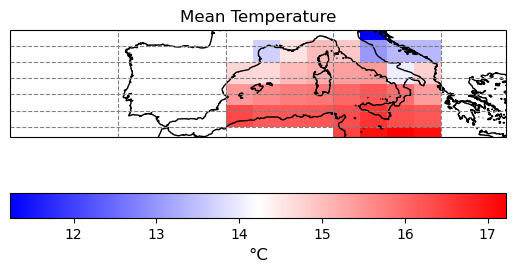

In [7]:
region = [-20, 26, 35, 45] 

plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree(central_longitude=0))
ax.set_global()
ax.set_extent(region, crs=cartopy.crs.PlateCarree())
ax.gridlines(linestyle='--',color='gray')
ax.coastlines()

temp_cartopy = ax.pcolormesh(sst_subset['lon'], sst_subset['lat'], climatology[0,:,:], transform=cartopy.crs.PlateCarree(), shading='auto',cmap='bwr')
colorbar = plt.colorbar(temp_cartopy, ax=ax, orientation='horizontal', label='Mean Temperature')
colorbar.set_label("°C",size=12,rotation=0)
plt.title("Mean Temperature")
plt.show()

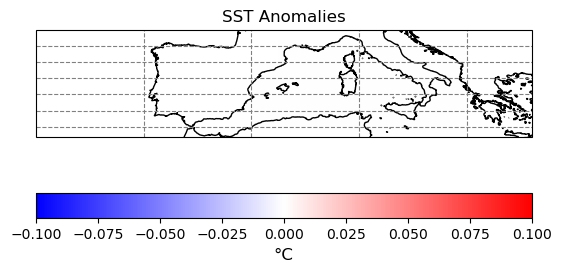

In [8]:
plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree(central_longitude=0))
ax.set_global()
ax.set_extent(region, crs=cartopy.crs.PlateCarree())
ax.gridlines(linestyle='--',color='gray')
ax.coastlines()

temp_cartopy = ax.pcolormesh(sst_subset['lon'], sst_subset['lat'], sst_anomalies[0,:,:], transform=cartopy.crs.PlateCarree(), shading='auto',cmap='bwr')
colorbar = plt.colorbar(temp_cartopy, ax=ax, orientation='horizontal', label='SST Anomalies')
colorbar.set_label("°C",size=12,rotation=0)
plt.title("SST Anomalies")
plt.show()

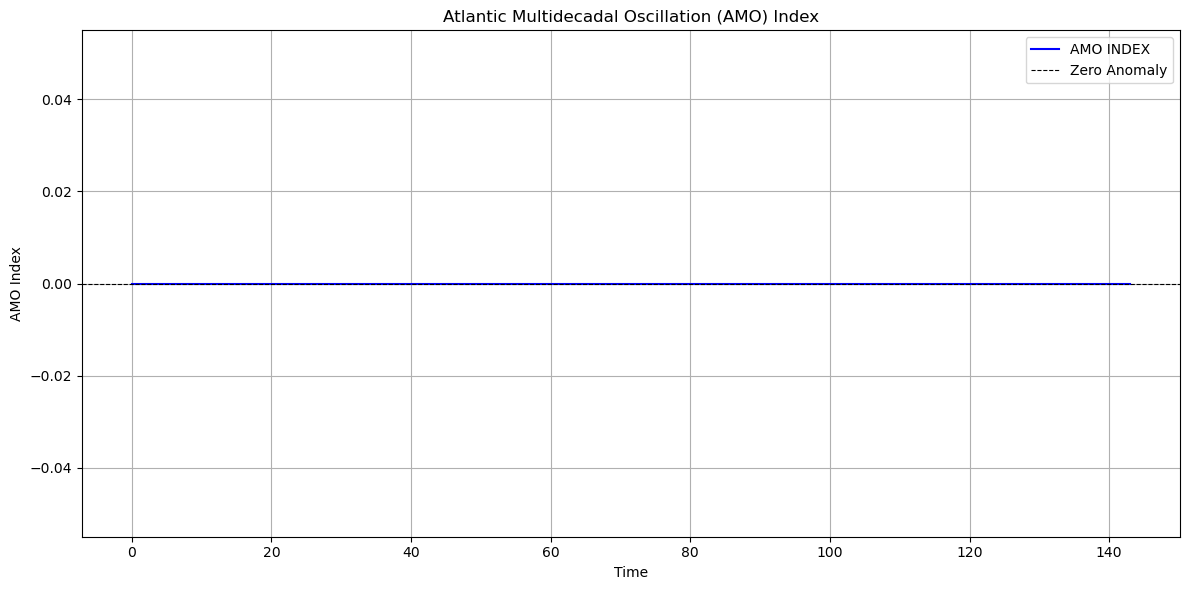

In [10]:
plt.figure(figsize=(12,6))
plt.plot(amo_index, label="AMO INDEX", color="b")
plt.axhline(0, color="k", linestyle="--", linewidth=0.8, label="Zero Anomaly")
plt.title("Atlantic Multidecadal Oscillation (AMO) Index")
plt.xlabel("Time")
plt.ylabel("AMO Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<span style="color:green"></span>Incorporate the processed SST data or derived indices into your drought prediction model as predictors or covariates.

In [11]:
era5_path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
full_era5 = xarray.open_zarr(gcs.get_mapper(era5_path), chunks=None)

precipitation_data = full_era5['mean_total_precipitation_rate'] #idk if it is precipitation TODO: print variable names to know
temperature_data = full_era5['temperature']

model_inputs = {
    'precipitation': precipitation_data,
    'temperature': temperature_data,
    'sst_anomalies': sst_anomalies,
    # TODO: Add other variables as needed
}

In [12]:
sst_anomalies = sst_anomalies.rename({'lat': 'latitude', 'lon': 'longitude'})
print(sst_anomalies.dims)

('time', 'latitude', 'longitude')


In [87]:
print(full_era5["mean_total_precipitation_rate"])
for i in full_era5:
    if "pre" in i:
        print(i)

<xarray.DataArray 'mean_total_precipitation_rate' (time: 1323648,
                                                   latitude: 721,
                                                   longitude: 1440)> Size: 5TB
[1374264299520 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 11MB 1900-01-01 ... 2050-12-31T23:00:00
Attributes:
    long_name:   Mean total precipitation rate
    short_name:  mtpr
    units:       kg m**-2 s**-1
10m_wind_gust_since_previous_post_processing
convective_precipitation
instantaneous_large_scale_surface_precipitation_fraction
large_scale_precipitation
large_scale_precipitation_fraction
maximum_2m_temperature_since_previous_post_processing
maximum_total_precipitation_rate_since_previous_post_processing
mean_convective_precipitation_rate
mean_large_scale_precipitation_fraction
mean_la

<span style="color:green">NEW</span> Add SST anomalies to the input variables of the NeuralGCM model
<span style="color:green">TODO</span> Error with too much data -> sliced or maybe on cluster

In [36]:
# Add SST anomalies to the input variables of the NeuralGCM model
#era5_with_sst = xr.Dataset(
#    {
#        'precipitation': full_era5['mean_total_precipitation_rate'],
#        'temperature': full_era5['temperature'],
#        'specific_humidity': full_era5['specific_humidity'],
#        'sst_anomalies': sst_anomalies,
#        # TODO: ADD remining inputs
#    },
#    coords={
#        'time': full_era5['time'],
#        'latitude': full_era5['latitude'],
#        'longitude': full_era5['longitude'],
#    }
#)

#full_era5 = xr.open_zarr(gcs.get_mapper(era5_path), chunks={'time': 100, 'latitude': 50, 'longitude': 50})

# Subset or downsample to reduce size
subset = full_era5.sel(latitude=slice(34, 51), longitude=slice(-20, 19), time=slice('2000-01-01', '2020-12-31'))

sst_anomalies = sst_anomalies.interpolate_na(dim='time', method='linear')
sst_anomalies = sst_anomalies.fillna(0)

sst_anomalies = sst_anomalies.interp(
    time=sliced_era5['time'],
    latitude=sliced_era5['latitude'],
    longitude=sliced_era5['longitude'],
    method='nearest'
)

print("SST_anomalies", sst_anomalies.shape)

# Add SST anomalies and relevant variables to the dataset
era5_with_sst = xr.Dataset(
    {
        'precipitation': subset['mean_total_precipitation_rate'],
        'temperature': subset['temperature'],
        'specific_humidity': subset['specific_humidity'],
        'sst_anomalies': sst_anomalies,
    },
    coords={
        'time': subset['time'],
        'latitude': subset['latitude'],
        'longitude': subset['longitude'],
    }
)

#result = era5_with_sst.mean(dim='time')

SST_anomalies (11, 721, 1440)


Regrid to NeuralGCM's native resolution: <span style="color:red">Rewrite it to use the sst data</span>.

In [ ]:
#start_date_test = "2014-12-10"
#end_date_test = "2014-12-20"

sliced_era5 = full_era5[['mean_total_precipitation_rate', 'temperature']].pipe(
        xarray_utils.selective_temporal_shift,
        variables=[],
        time_shift='24 hours',
)
sliced_era5 = sliced_era5.sel(time=slice(start_date, end_date, data_inner_steps))

# Add SST anomalies
sst_aligned = sst_anomalies.sel(time=slice(start_date, end_date))
sliced_era5['sst_anomalies'] = sst_aligned
sliced_era5 = xarray_utils.fill_nan_with_nearest(sliced_era5)


##old code#

#sliced_era5 = (
#    full_era5[['mean_total_precipitation_rate', 'temperature']]
#    .pipe(
#        xarray_utils.selective_temporal_shift,
#        variables=[],
#        time_shift='24 hours',
#    )
#    .sel(time=slice(start_date, end_date, data_inner_steps))
#    .compute()
#)


#sliced_era5['sst_anomalies'] = sst_anomalies.sel(
#    time=slice(start_date, end_date)
#)

In [35]:
era5_grid = spherical_harmonic.Grid(
    latitude_nodes=full_era5.sizes['latitude'],
    longitude_nodes=full_era5.sizes['longitude'],
    latitude_spacing=xarray_utils.infer_latitude_spacing(full_era5.latitude),
    longitude_offset=xarray_utils.infer_longitude_offset(full_era5.longitude),
)
regridder = horizontal_interpolation.ConservativeRegridder(
    era5_grid, model.data_coords.horizontal, skipna=True
)
eval_era5 = xarray_utils.regrid(sliced_era5, regridder)
eval_era5 = xarray_utils.fill_nan_with_nearest(eval_era5)

ValueError: NaN mask is not fixed across non-spatial dimensions

In [23]:
print(sst_anomalies.dims)
print(sst_anomalies)

('time', 'latitude', 'longitude')
<xarray.DataArray 'tos' (time: 144, latitude: 6, longitude: 8)> Size: 28kB
array([[[nan, nan, nan, ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [nan,  0.,  0., ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0., nan, nan]],

       [[nan, nan, nan, ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [nan,  0.,  0., ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0., nan, nan]],

       [[nan, nan, nan, ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [nan,  0.,  0., ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0., nan, nan]],
...
       [[nan, nan, nan, ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...

<span style="color:green">NEW</span>:Ensure that the combined dataset adheres to NeuralGCM’s expected format.

In [145]:
model_inputs = {
    variable: era5_with_sst[variable].values for variable in era5_with_sst.data_vars
}

MemoryError: Unable to allocate 5.00 TiB for an array with shape (1323648, 721, 1440) and data type float32

## Make the forecast

See {doc}`trained_models` for details.

In [ ]:

# Parameters for 30-year rollout
years = 30
days_per_year = 365  # Exclude leap years for simplicity
inner_steps = 24  # Save model outputs every 24 hours
hours_per_day = 24
outer_steps = (days_per_year * years * hours_per_day) // inner_steps  # Total steps for 30 years
timedelta = np.timedelta64(inner_steps, 'h')  # Time interval between model outputs
times = np.arange(outer_steps) * inner_steps  # Time axis in hours

# Initialize model state
print("Initializing model state...")
inputs = model.inputs_from_xarray(eval_era5.isel(time=0))
input_forcings = model.forcings_from_xarray(eval_era5.isel(time=0))
rng_key = jax.random.key(42)  # Optional for deterministic models
initial_state = model.encode(inputs, input_forcings, rng_key)

# Use persistence for forcing variables (e.g., SST and sea ice cover)
print("Using persistent forcing variables...")
all_forcings = model.forcings_from_xarray(eval_era5.head(time=1))

# Make forecast
print(f"Starting 30-year rollout with {outer_steps} steps...")
final_state, predictions = model.unroll(
    initial_state,
    all_forcings,
    steps=outer_steps,
    timedelta=timedelta,
    start_with_input=True,
)

# Convert predictions to xarray dataset
print("Converting predictions to xarray.Dataset...")
predictions_ds = model.data_to_xarray(predictions, times=times)

# Save results to a NetCDF file
output_file = "30_year_rollout_predictions.nc"
print(f"Saving results to {output_file}...")
predictions_ds.to_netcdf(output_file)

# Final message
print("30-year rollout completed successfully.")

## Compare forecast to ERA5

See [WeatherBench2](https://sites.research.google/weatherbench/) for more comprehensive evaluations and archived NeuralGCM forecasts.

Can stay like this

In [ ]:
# Selecting ERA5 targets from exactly the same time slice
target_trajectory = model.inputs_from_xarray(
    eval_era5
    .thin(time=(inner_steps // data_inner_steps))
    .isel(time=slice(outer_steps))
)
target_data_ds = model.data_to_xarray(target_trajectory, times=times)

combined_ds = xarray.concat([target_data_ds, predictions_ds], 'model')
combined_ds.coords['model'] = ['ERA5', 'NeuralGCM']

In [ ]:
# Visualize ERA5 vs NeuralGCM trajectories
combined_ds.specific_humidity.sel(level=850).plot(
    x='longitude', y='latitude', row='time', col='model', robust=True, aspect=2, size=2
);

## Data Analysis

## Adding later

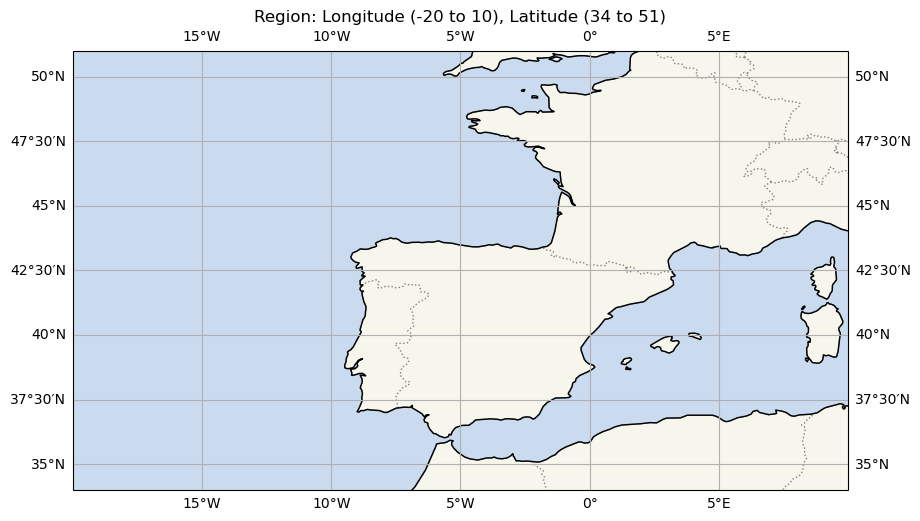

In [15]:
from PIL import Image
from IPython.display import display

img = Image.open('images/Spain_range_1.png')
display(img)

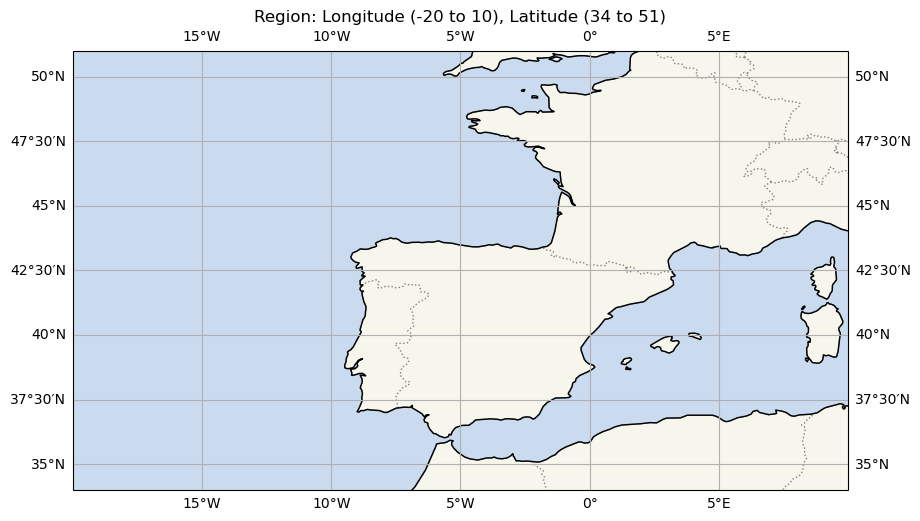

In [16]:
from PIL import Image
from IPython.display import display

img = Image.open('images/Spain_range_1.png')
display(img)

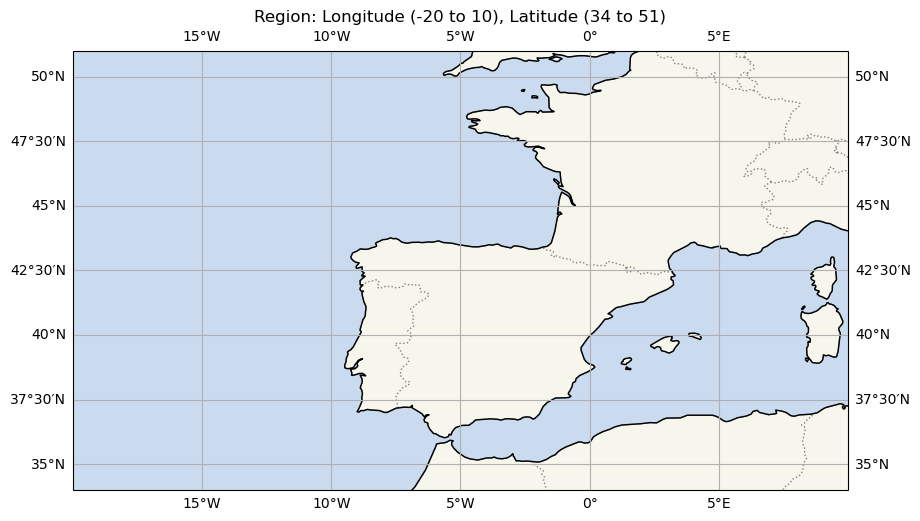

In [17]:
img = Image.open('images/Spain_range_1.png')
display(img)